In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
data1 = pd.read_csv('./UnivariateData/6.csv', header=None, names=['x', 'y'])  # Univariate data
data2 = pd.read_csv('./BivariateData/6.csv', header=None, names=['x1', 'x2', 'y'])  # Bivariate data

# Split datasets into training and test sets (70% training, 30% test) without using sklearn
def train_test_split_manual(data, test_size=0.3, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(data))
    test_count = int(len(data) * test_size)
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split datasets manually
train_data1, test_data1 = train_test_split_manual(data1, test_size=0.3)
train_data2, test_data2 = train_test_split_manual(data2, test_size=0.3)

# Part 1: Polynomial Regression for Dataset 1 (Univariate)

### Polynomial Regression Functions

In [2]:
# Function to generate polynomial features
def polynomial_features(x, degree):
    return np.vstack([x ** i for i in range(degree + 1)]).T

# Function to perform polynomial regression
def polynomial_regression(x, y, degree, reg_lambda=0):
    X = polynomial_features(x, degree)
    I = np.eye(X.shape[1])
    # Regularized least squares solution
    weights = np.linalg.inv(X.T @ X + reg_lambda * I) @ X.T @ y
    return weights

# Prediction function
def predict_polynomial(x, weights):
    X = polynomial_features(x, len(weights) - 1)
    return X @ weights

### Cross-Validation to Select Best Model Complexity and Regularization

In [3]:
# Manual k-Fold Cross-Validation
def cross_validate(train_data, max_degree, reg_lambdas, k=5):
    fold_size = len(train_data) // k
    best_mse = float('inf')
    best_params = None

    for degree in range(2, max_degree + 1):
        for reg_lambda in reg_lambdas:
            mse_total = 0
            for fold in range(k):
                start, end = fold * fold_size, (fold + 1) * fold_size
                validation_fold = train_data.iloc[start:end]
                training_fold = pd.concat([train_data.iloc[:start], train_data.iloc[end:]])

                weights = polynomial_regression(
                    training_fold['x'].values, training_fold['y'].values, degree, reg_lambda
                )
                predictions = predict_polynomial(validation_fold['x'].values, weights)
                mse = np.mean((validation_fold['y'].values - predictions) ** 2)
                mse_total += mse

            avg_mse = mse_total / k
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (degree, reg_lambda)

    return best_params

### Generate Plots for Dataset 1

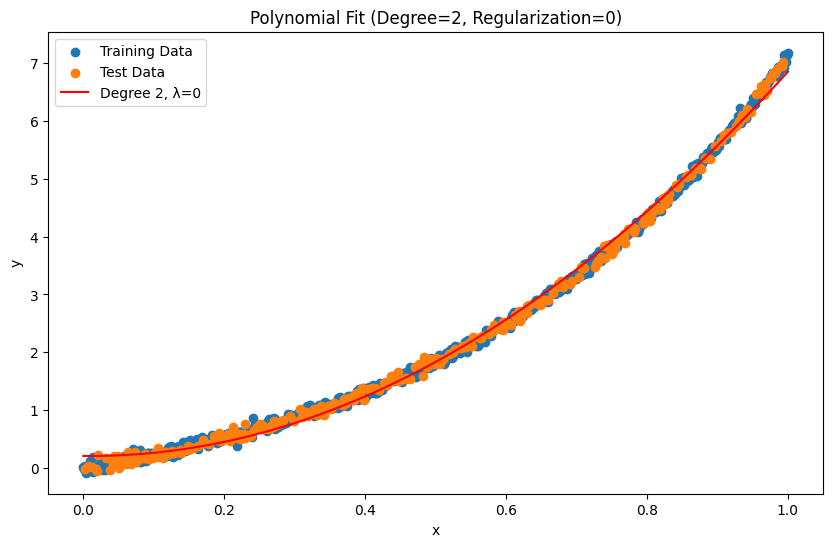

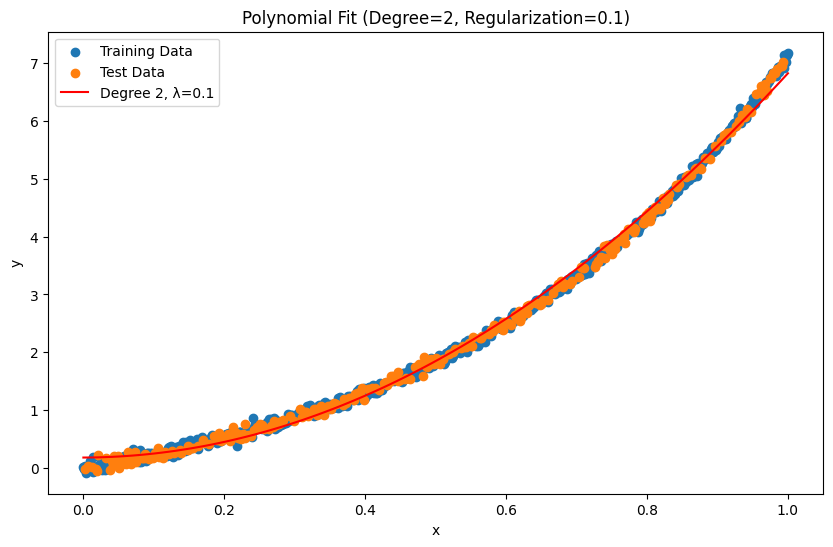

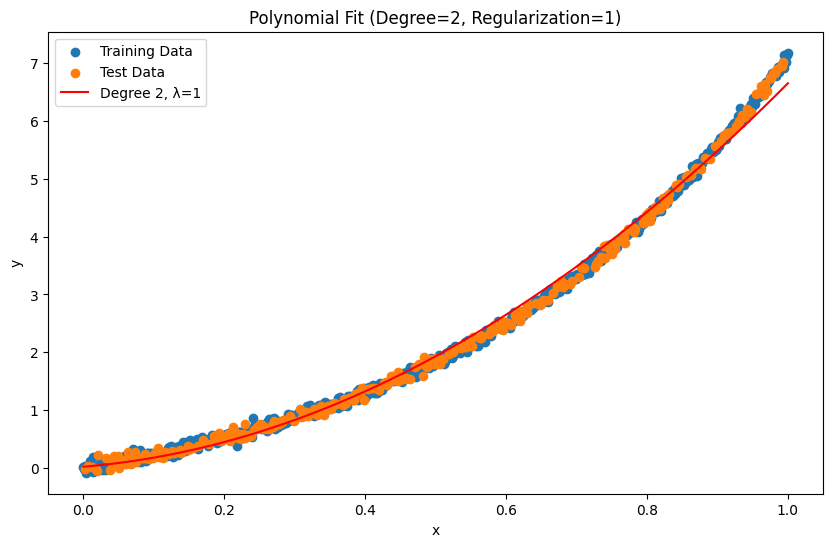

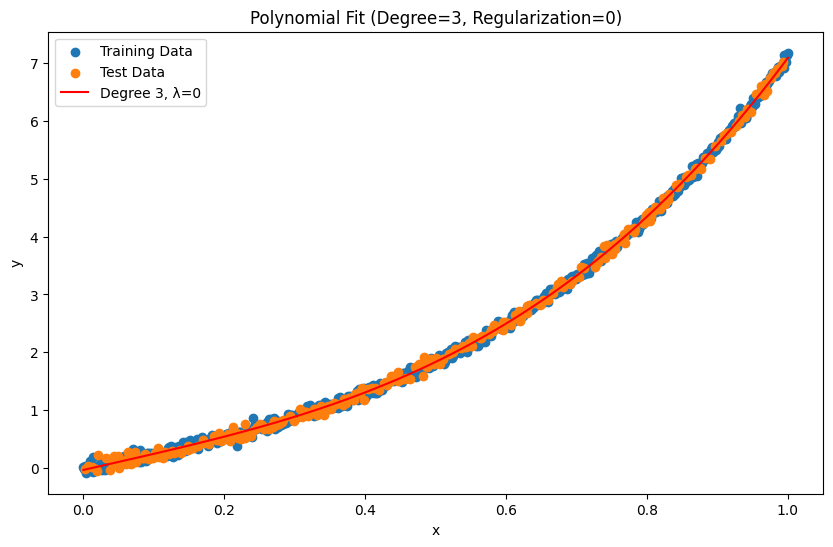

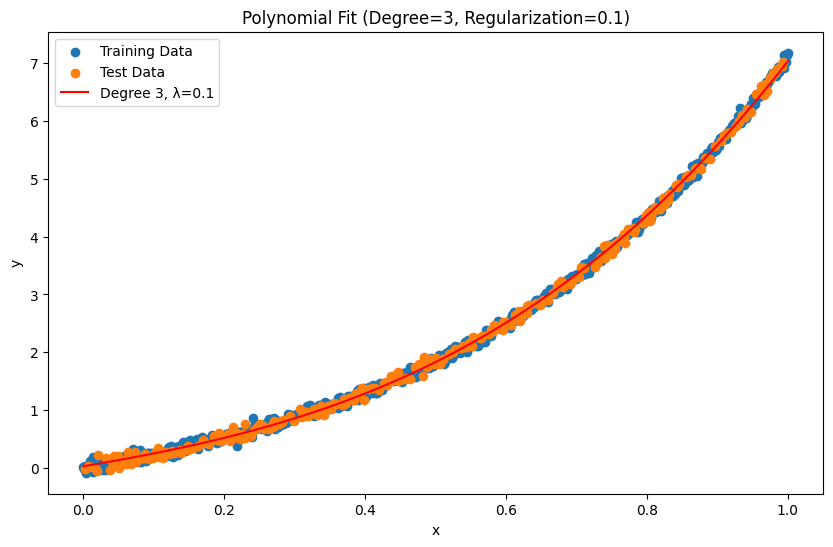

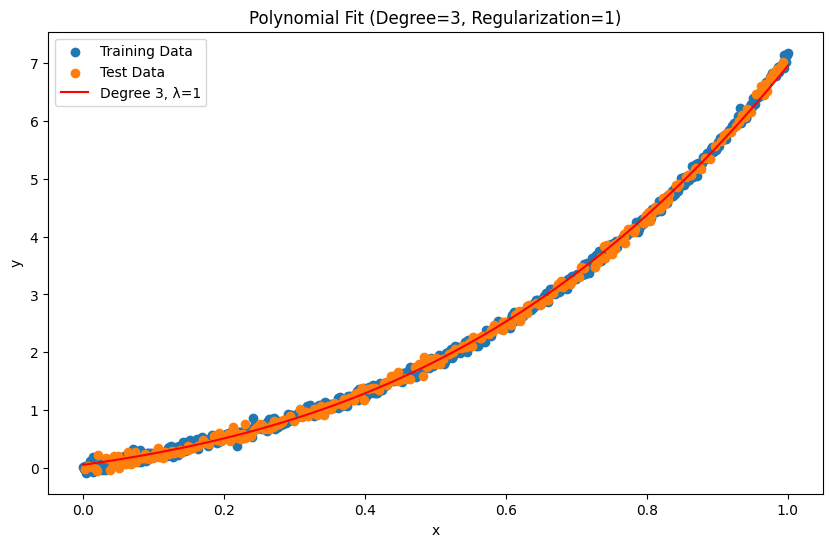

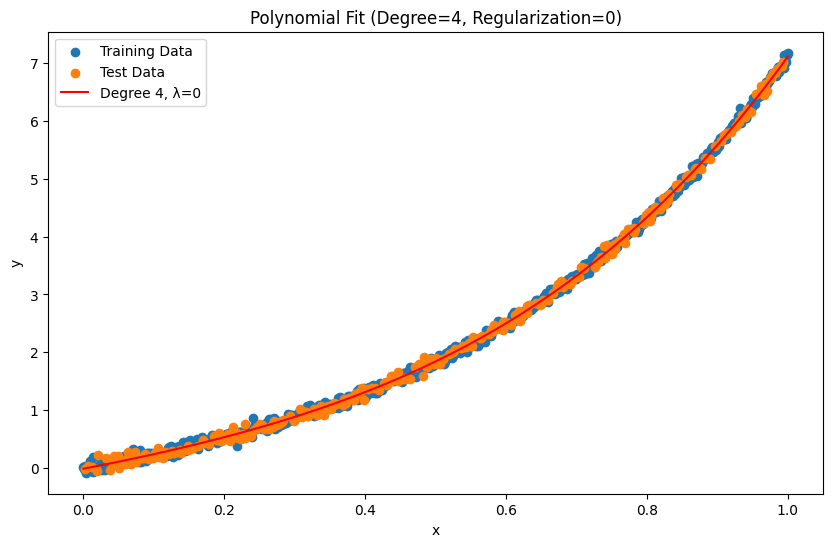

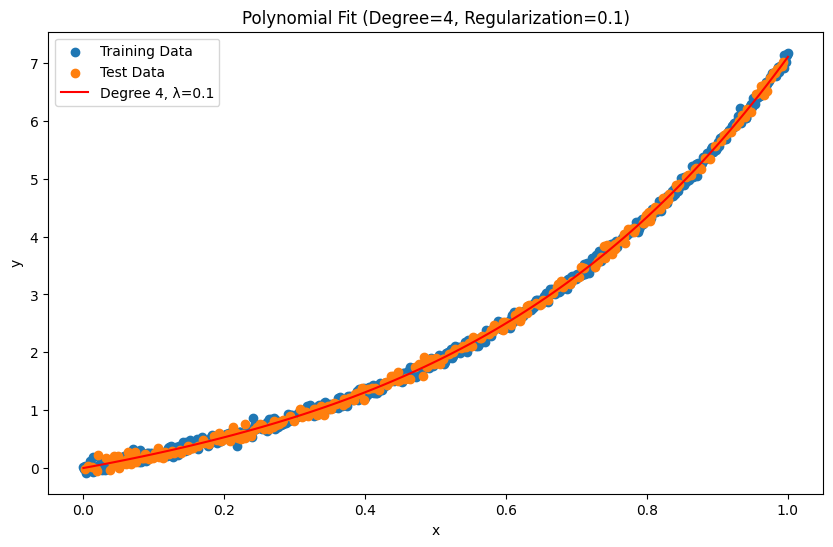

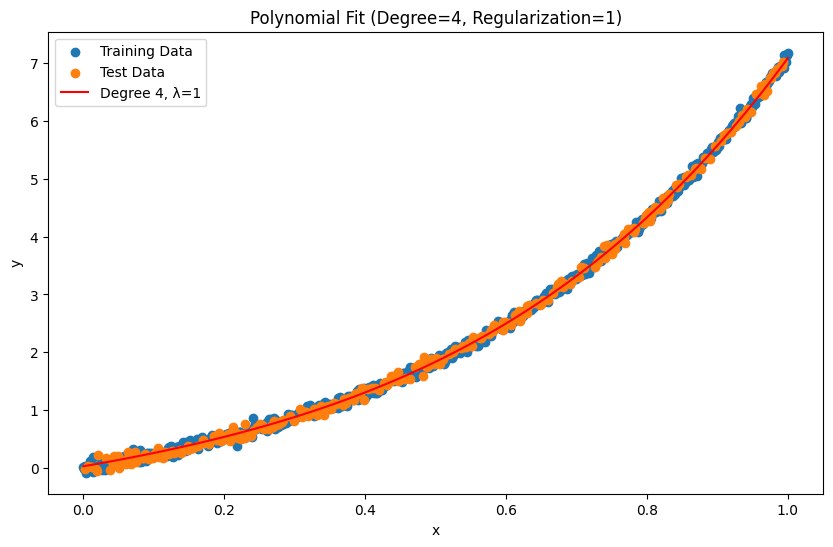

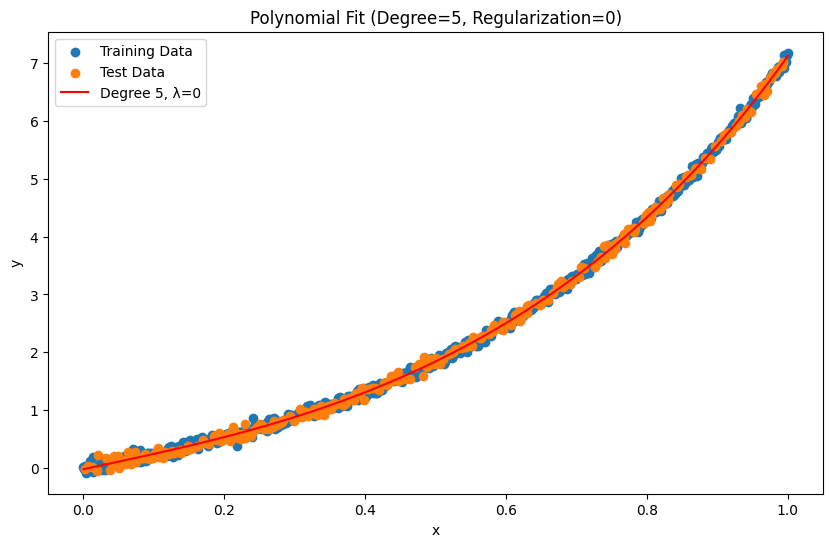

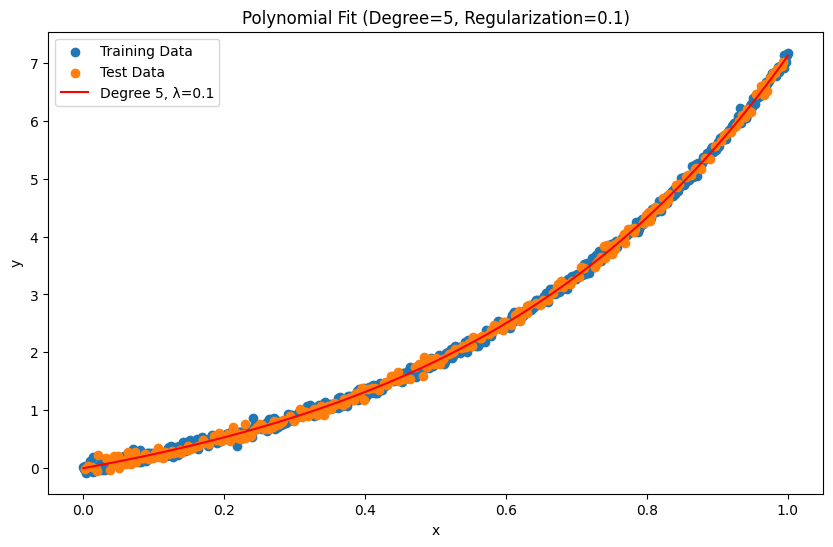

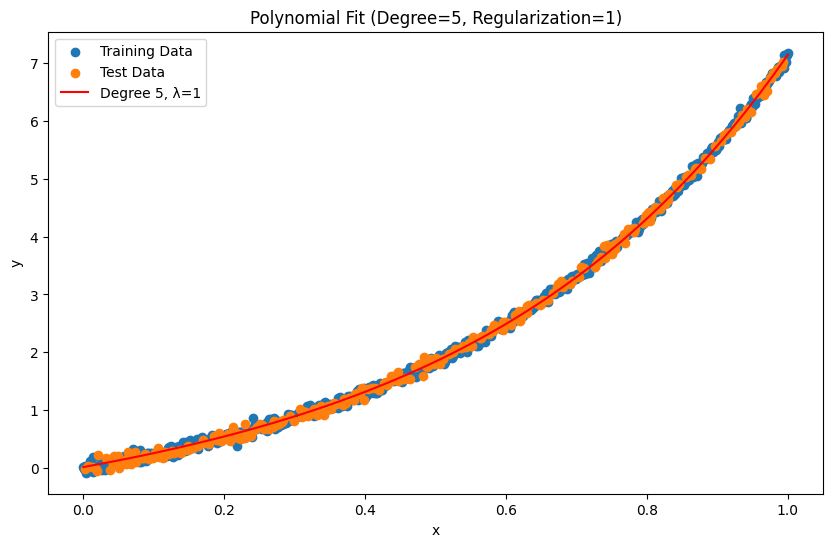

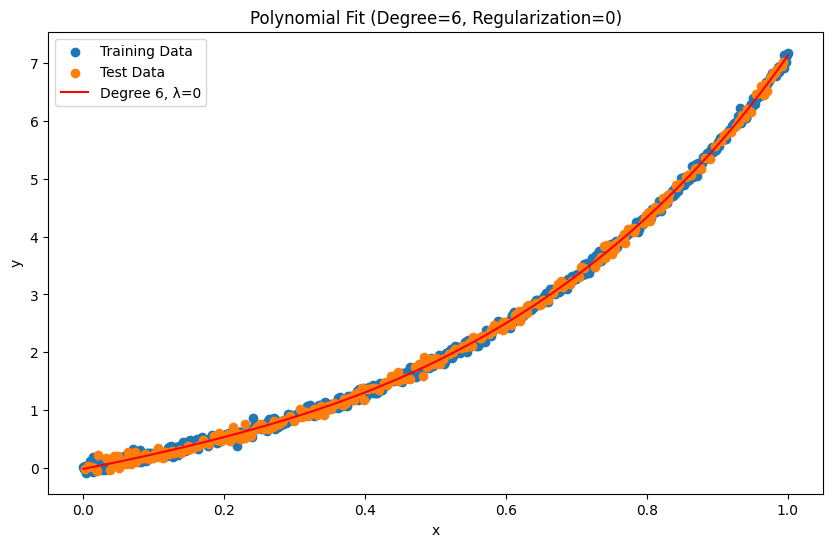

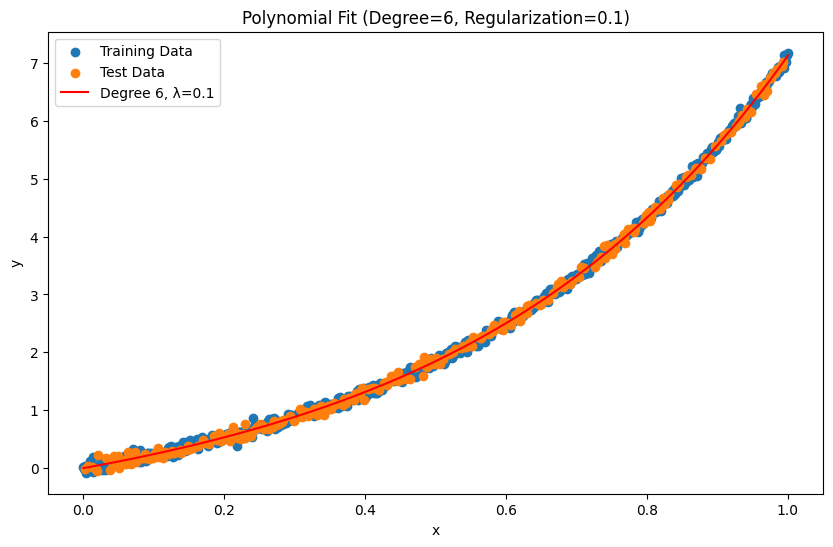

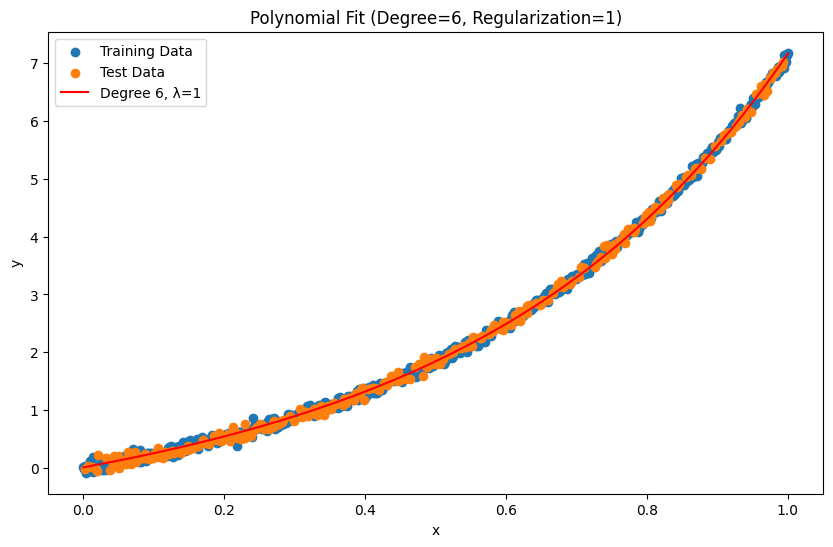

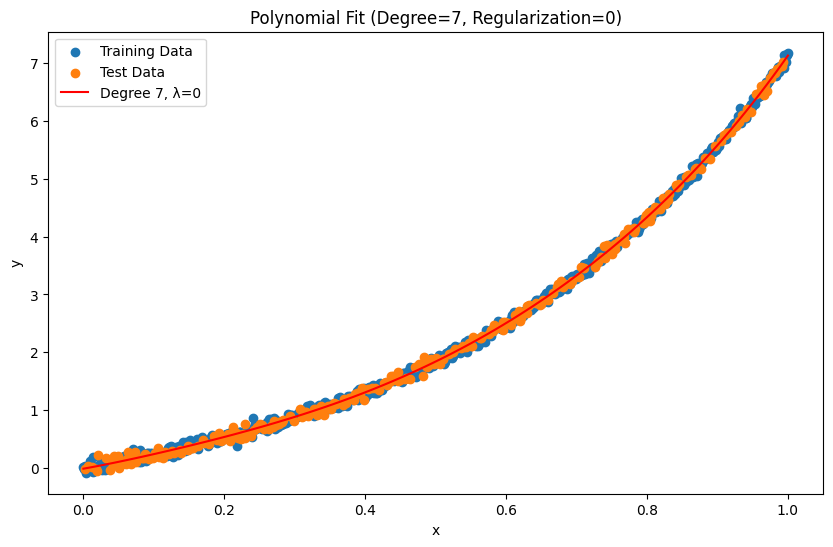

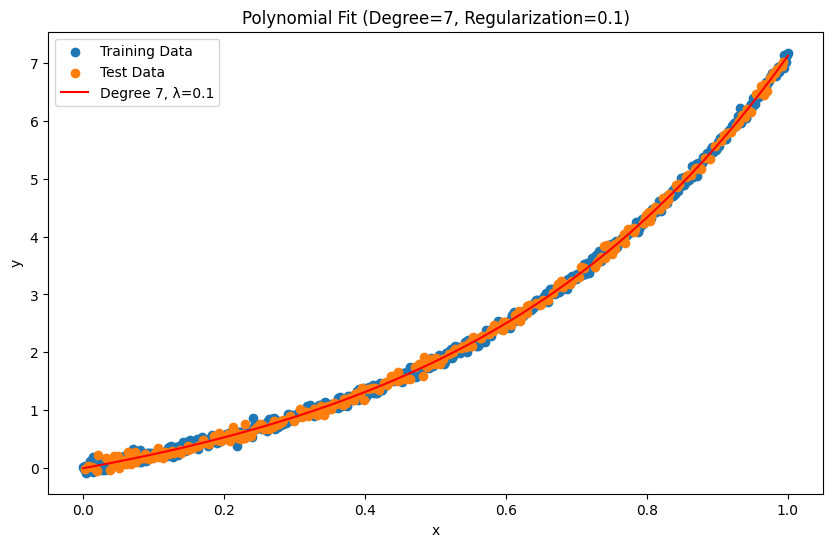

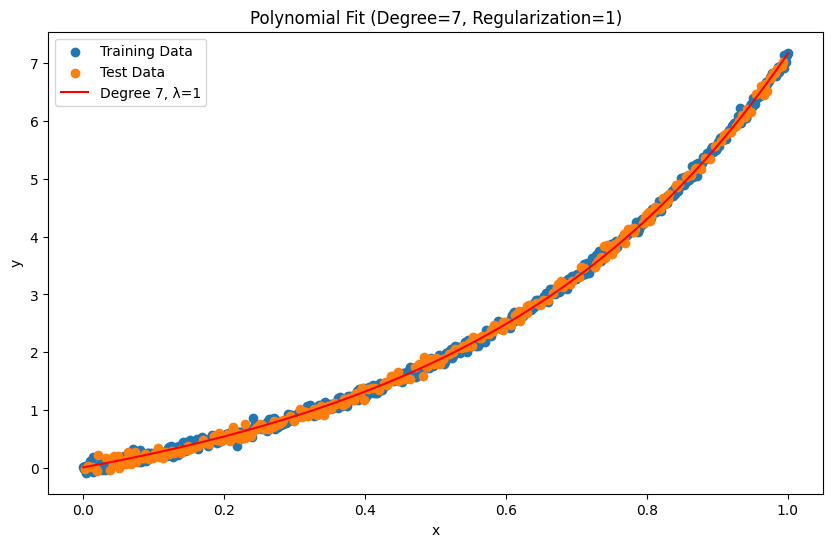

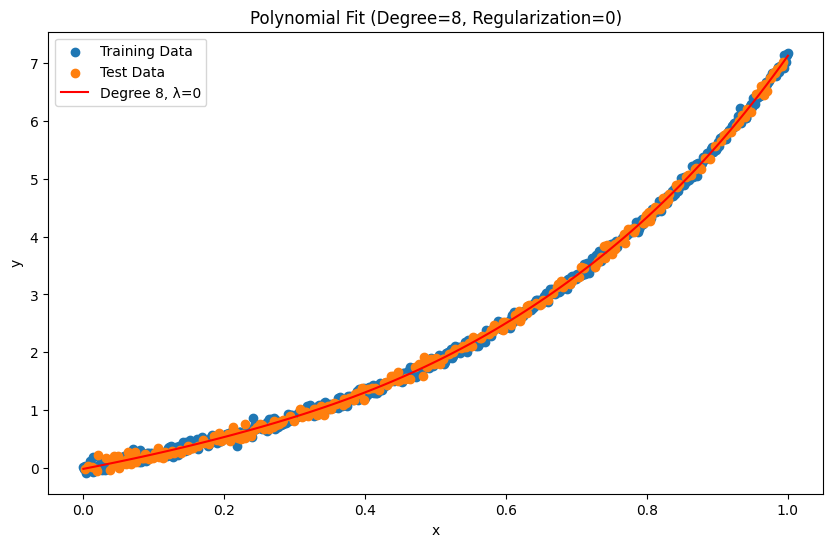

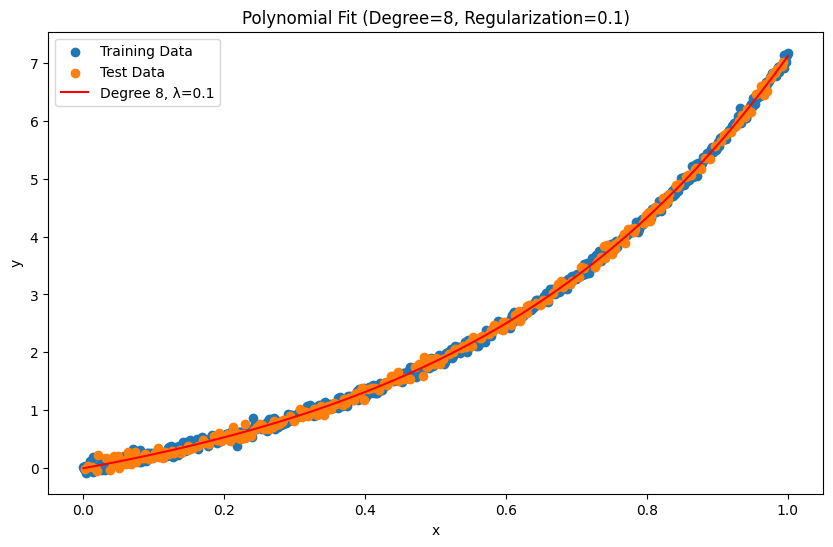

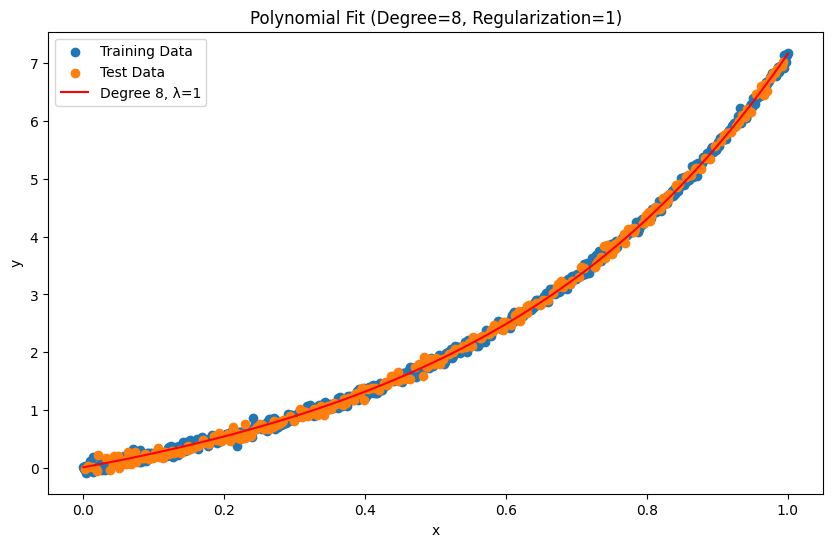

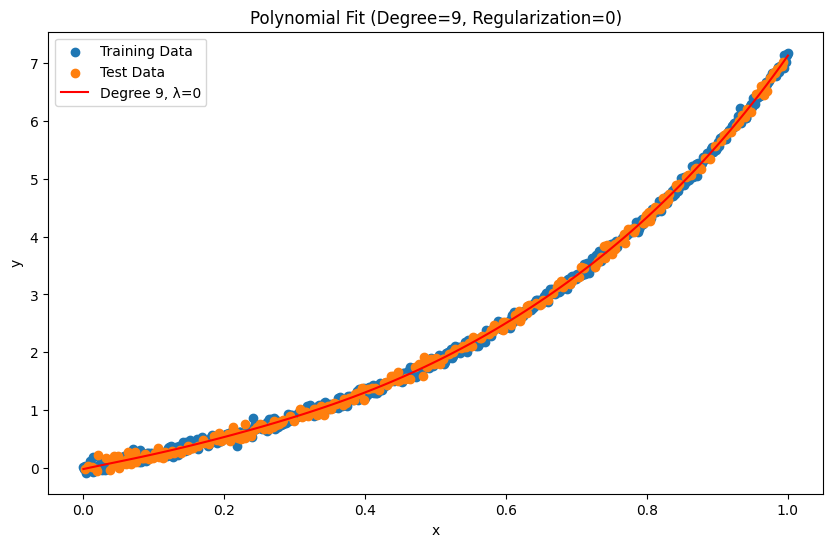

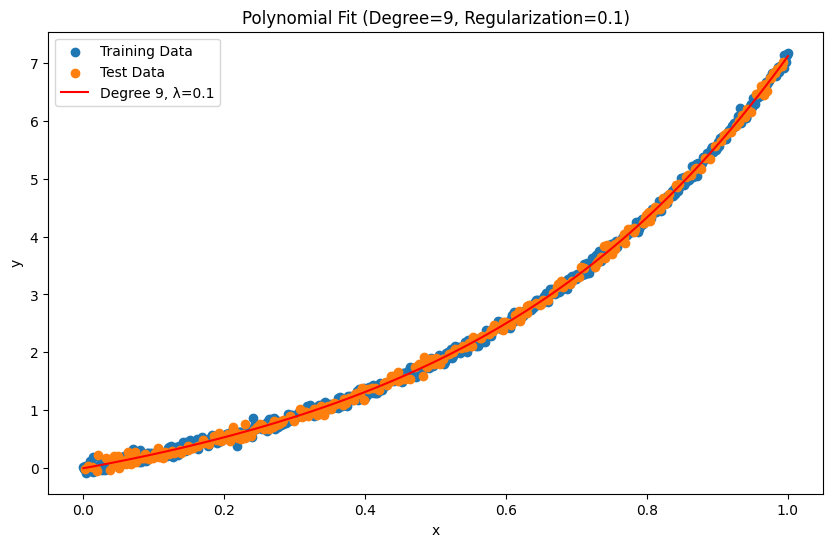

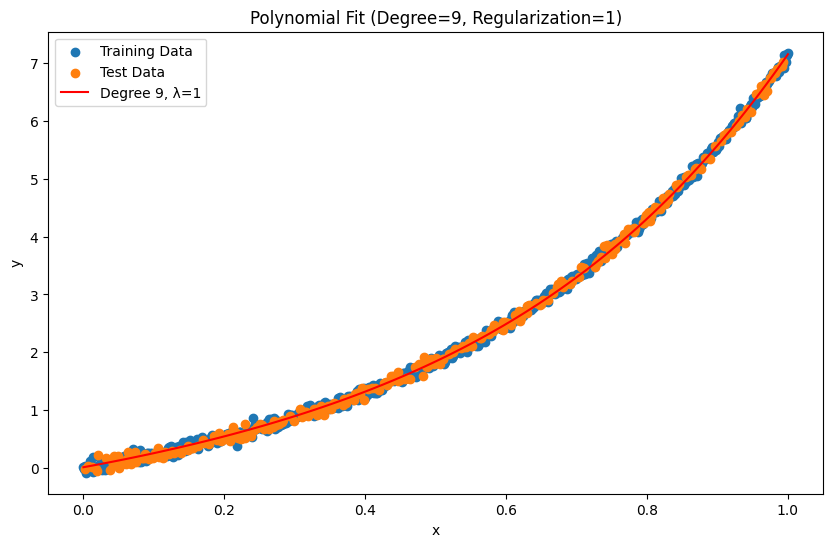

In [4]:
# Plotting for Dataset 1
def plot_polynomial_fit(train_data, test_data, degrees, reg_lambda_values, train_sizes):
    x_train = train_data['x'].values
    y_train = train_data['y'].values
    x_test = test_data['x'].values
    y_test = test_data['y'].values

    for degree in degrees:
        for reg_lambda in reg_lambda_values:
            weights = polynomial_regression(x_train, y_train, degree, reg_lambda)
            train_predictions = predict_polynomial(x_train, weights)
            test_predictions = predict_polynomial(x_test, weights)

            # Plot training and test data predictions
            plt.figure(figsize=(10, 6))
            plt.scatter(x_train, y_train, label='Training Data')
            plt.scatter(x_test, y_test, label='Test Data')
            x_line = np.linspace(0, 1, 100)
            y_line = predict_polynomial(x_line, weights)
            plt.plot(x_line, y_line, color='red', label=f'Degree {degree}, λ={reg_lambda}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Polynomial Fit (Degree={degree}, Regularization={reg_lambda})')
            plt.legend()
            plt.show()

# Example of calling plot function for a subset of training sizes
plot_polynomial_fit(train_data1, test_data1, degrees=range(2, 10), reg_lambda_values=[0, 0.1, 1], train_sizes=[10, 50, 100, len(train_data1)])

# Part 2: Gaussian Basis Functions Model for Dataset 2 (Bivariate)

### Gaussian Basis Functions

In [5]:
# Function to initialize Gaussian basis function centers using K-means clustering from scratch
def k_means_init(X, k):
    centers = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(10):  # Run fixed number of iterations
        distances = np.linalg.norm(X[:, None] - centers, axis=2)
        clusters = np.argmin(distances, axis=1)
        centers = np.array([X[clusters == j].mean(axis=0) for j in range(k)])
    return centers

# Generate Gaussian basis functions
def gaussian_basis_functions(X, centers, sigma):
    return np.exp(-np.sum((X[:, None] - centers) ** 2, axis=2) / (2 * sigma ** 2))

# Linear Regression with Gaussian Basis
def gaussian_basis_regression(X, y, num_basis, reg_lambda=0):
    centers = k_means_init(X, num_basis)
    sigma = np.mean(np.linalg.norm(centers - centers[:, None], axis=2)) / np.sqrt(2 * num_basis)
    Phi = gaussian_basis_functions(X, centers, sigma)
    I = np.eye(Phi.shape[1])
    weights = np.linalg.inv(Phi.T @ Phi + reg_lambda * I) @ Phi.T @ y
    return weights, centers, sigma

# Prediction function
def predict_gaussian_basis(X, weights, centers, sigma):
    Phi = gaussian_basis_functions(X, centers, sigma)
    return Phi @ weights

### Generate Plots for Dataset 2

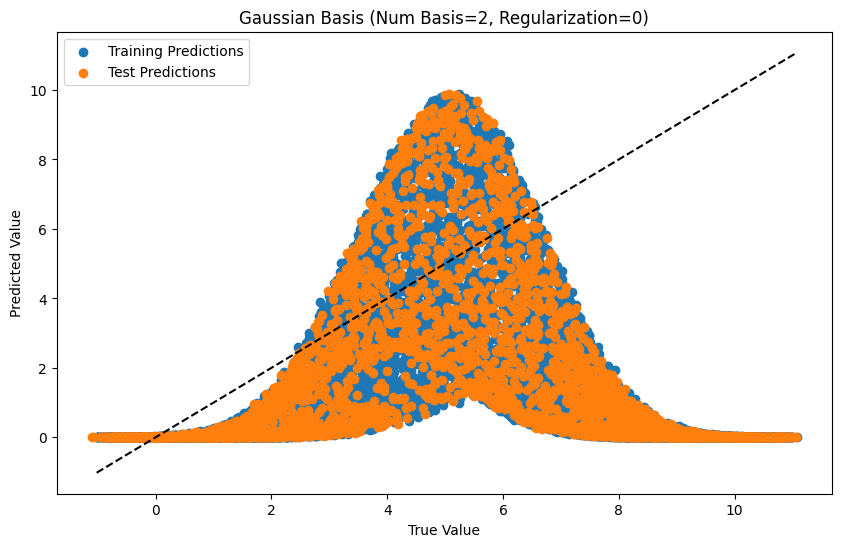

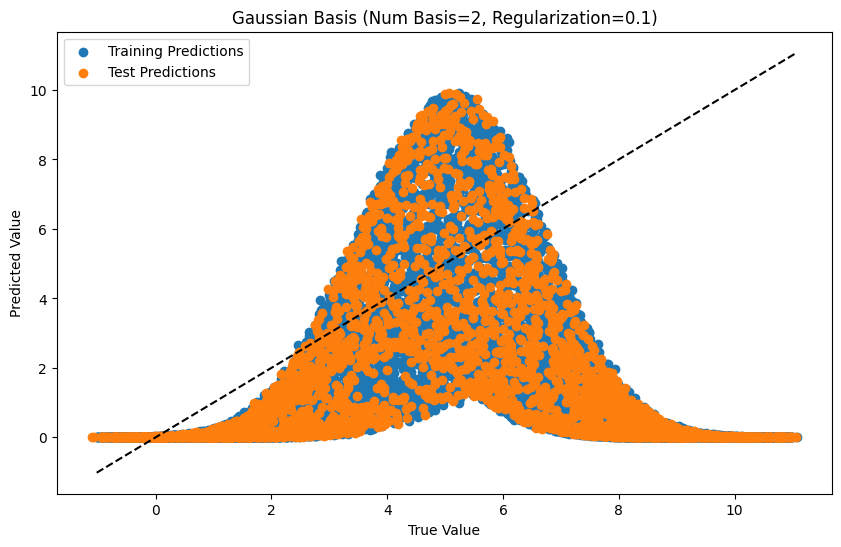

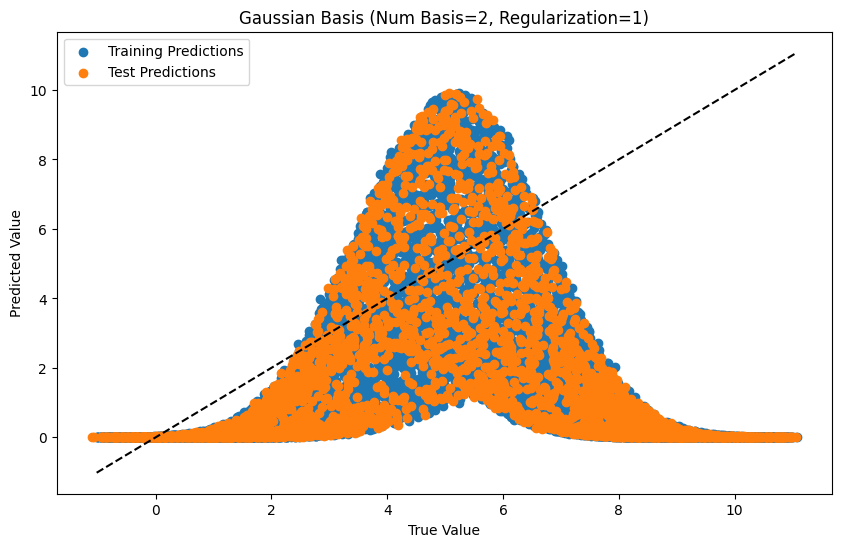

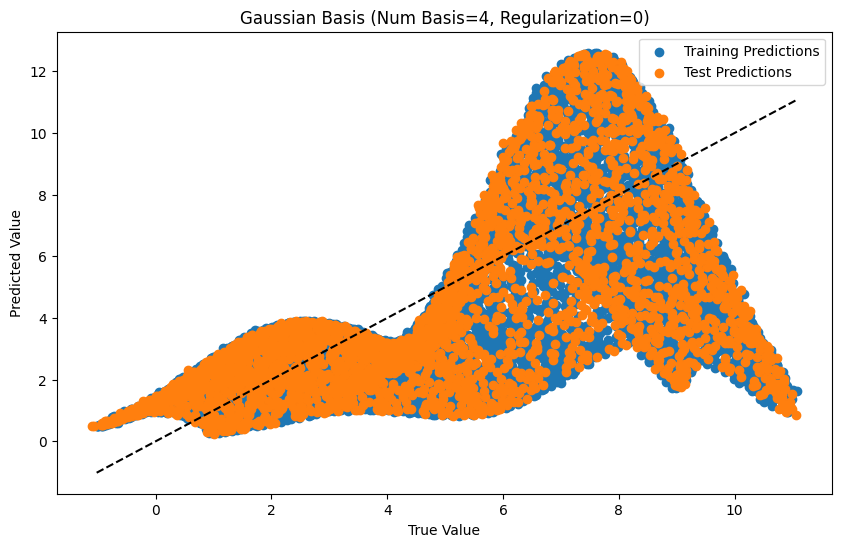

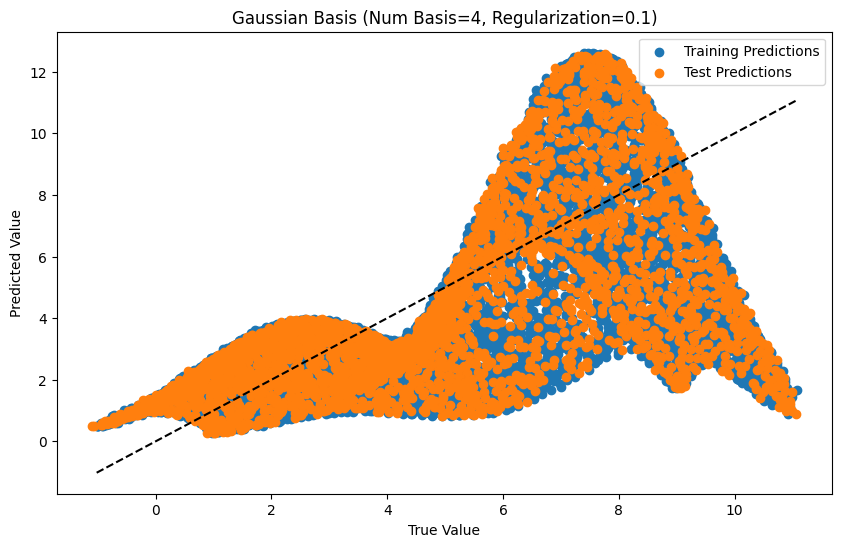

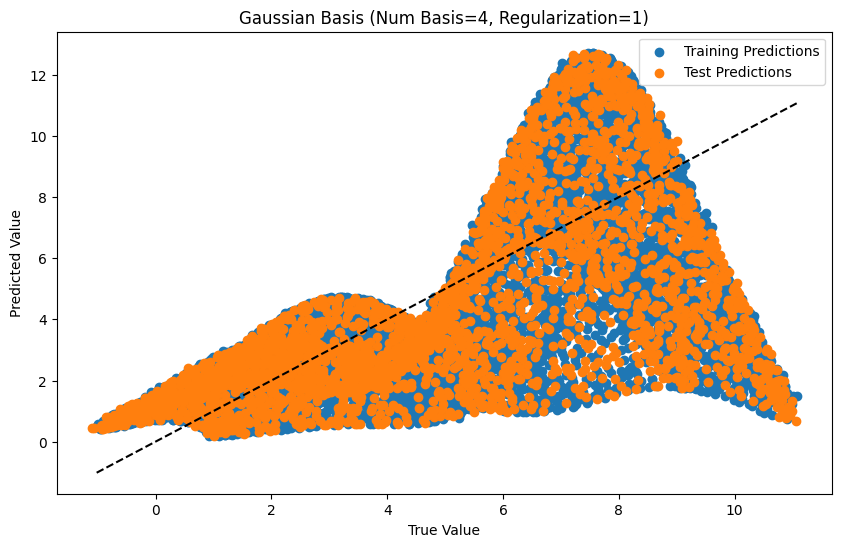

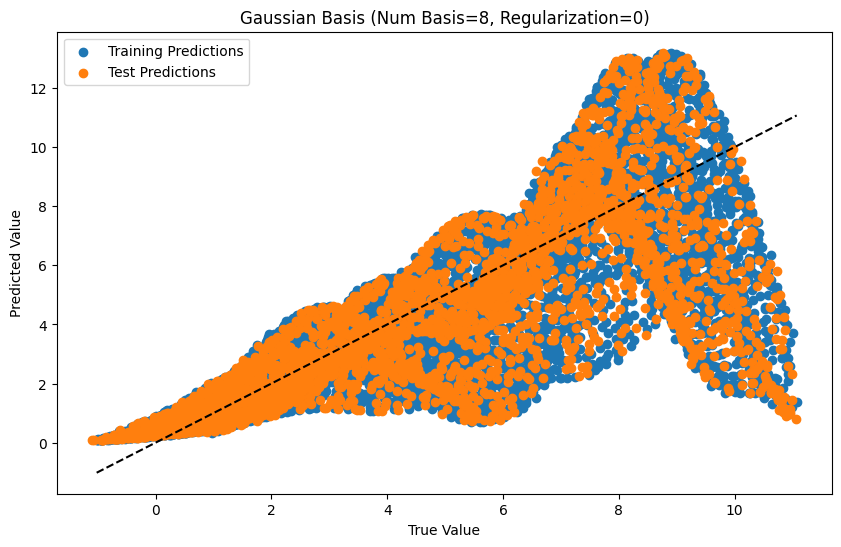

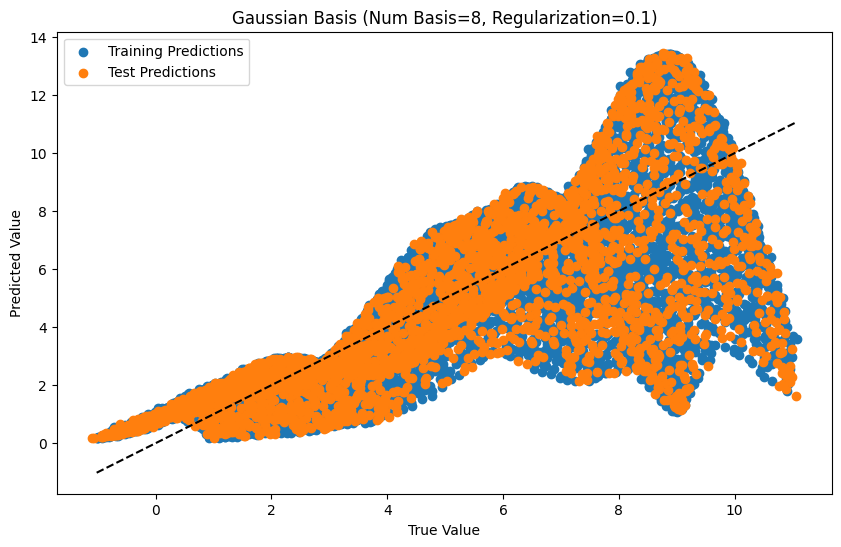

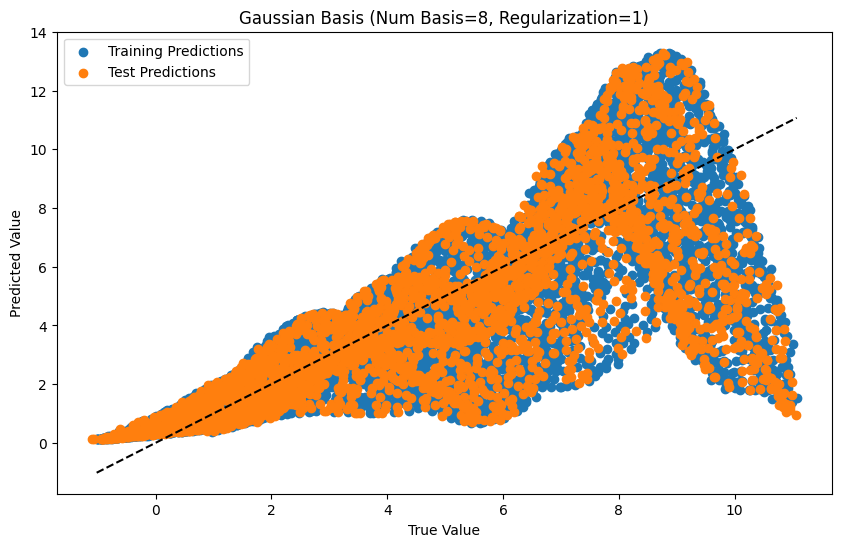

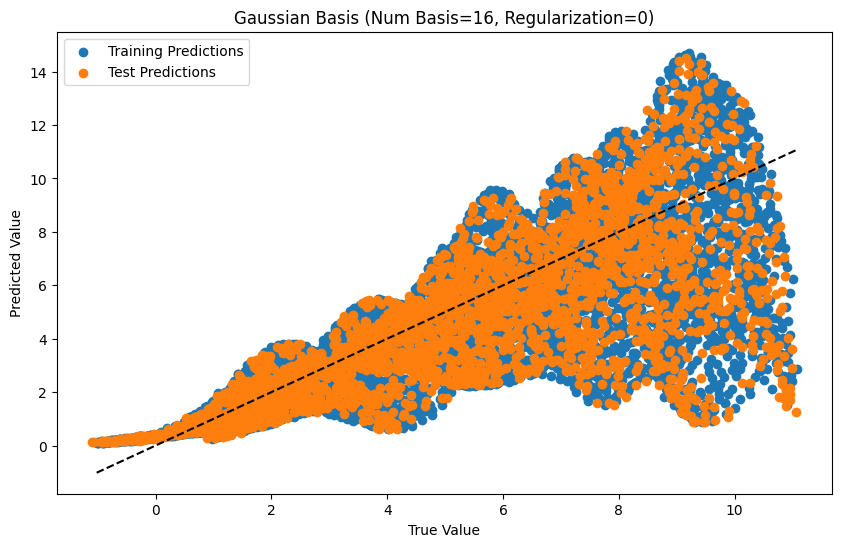

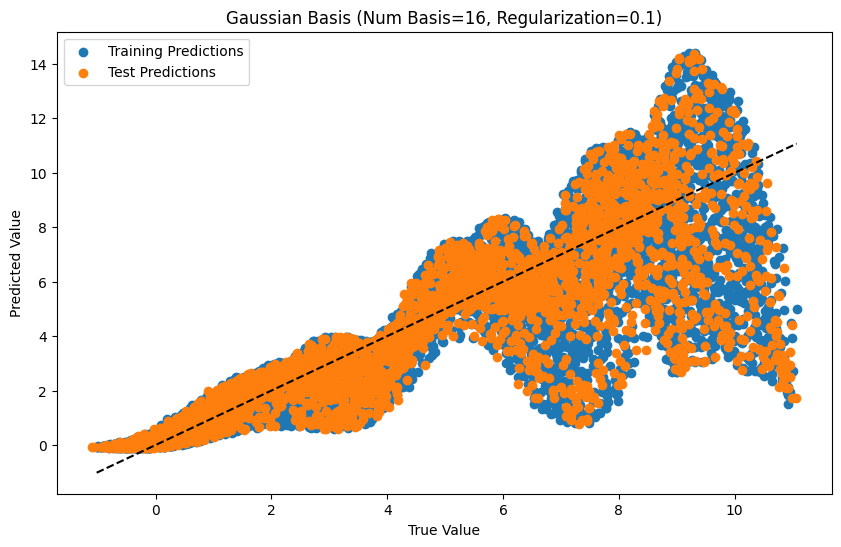

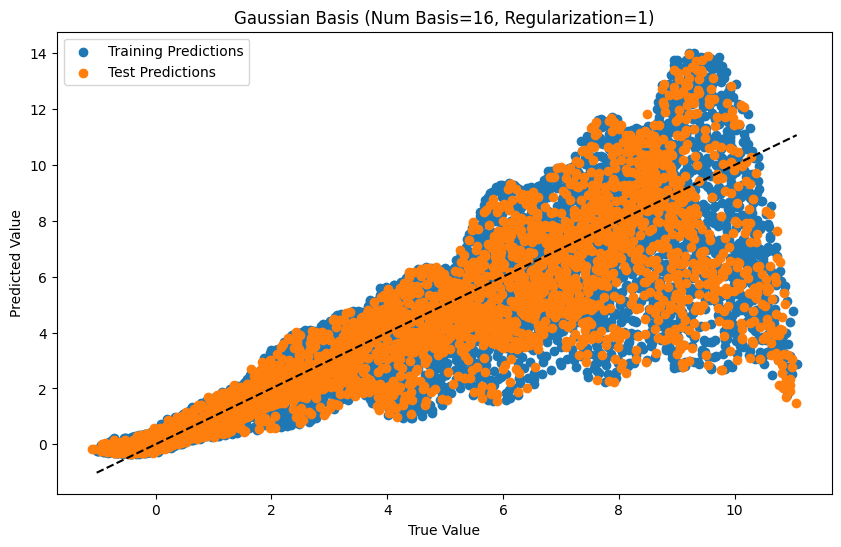

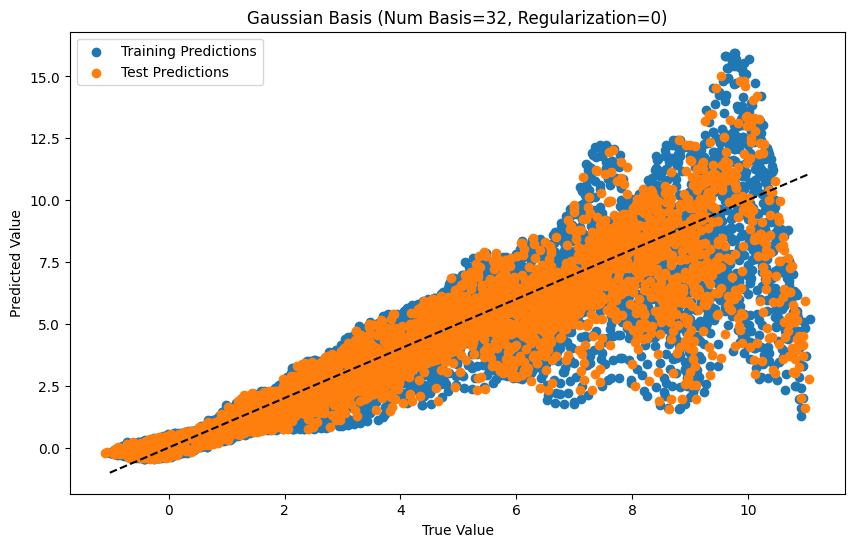

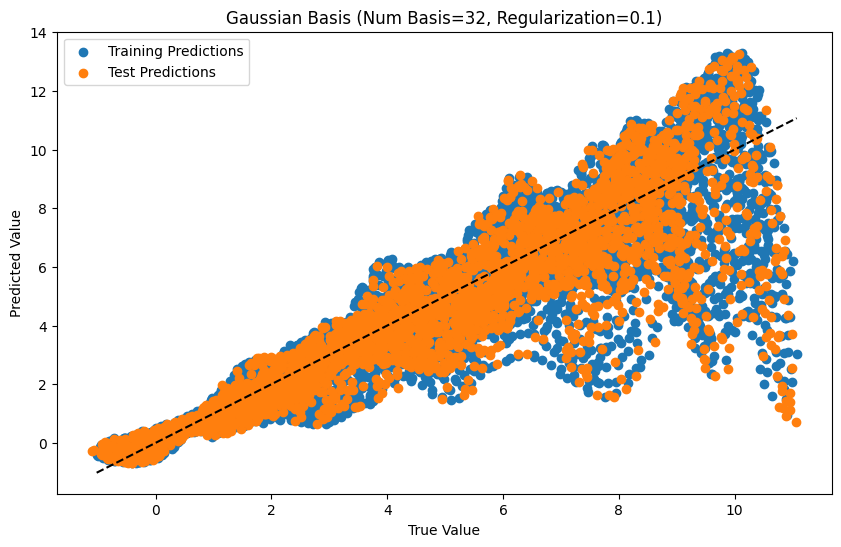

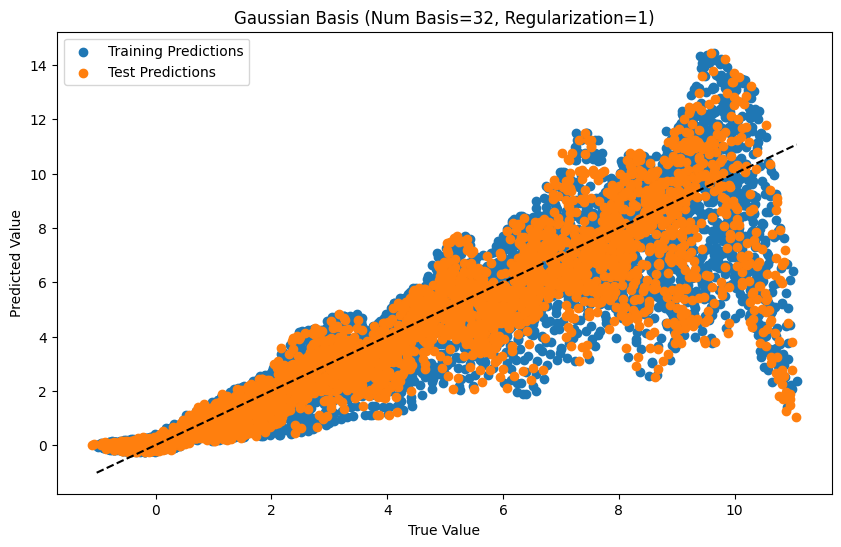

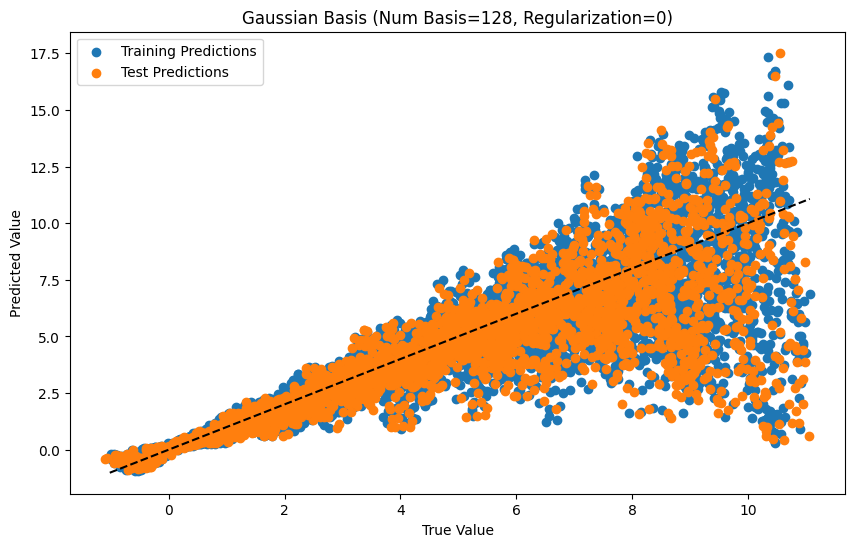

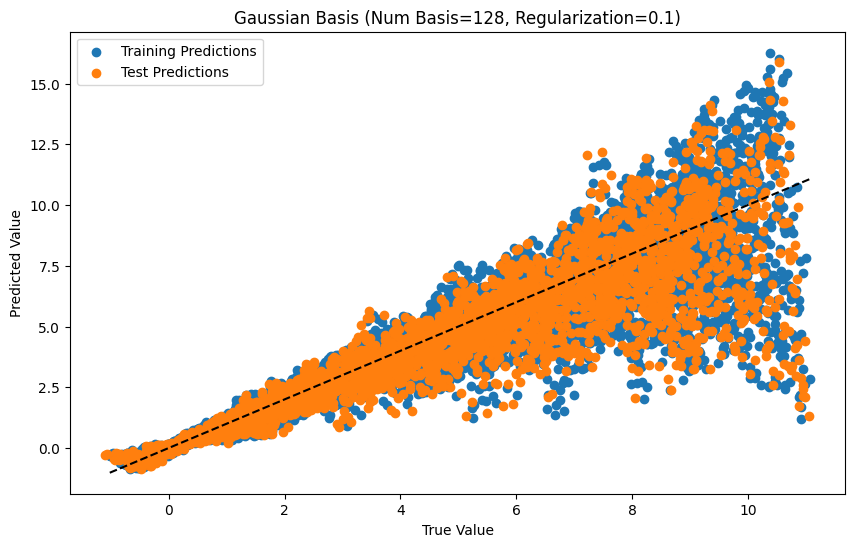

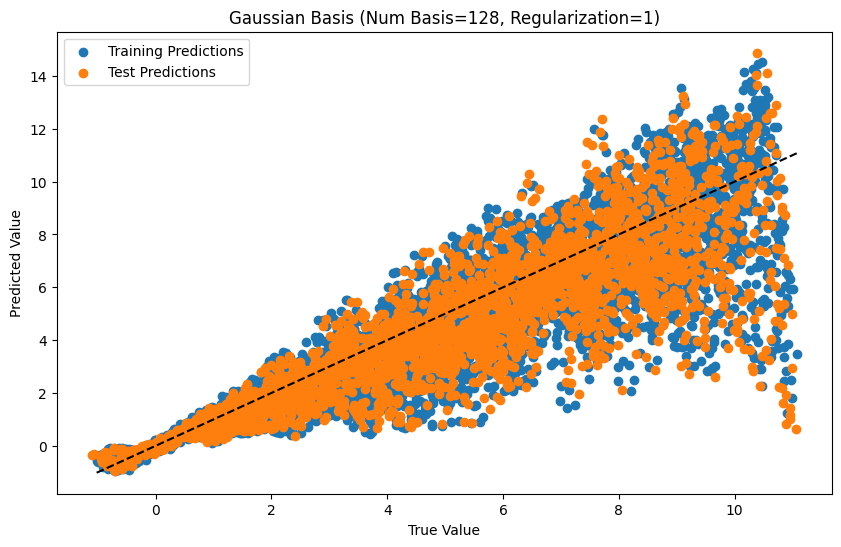

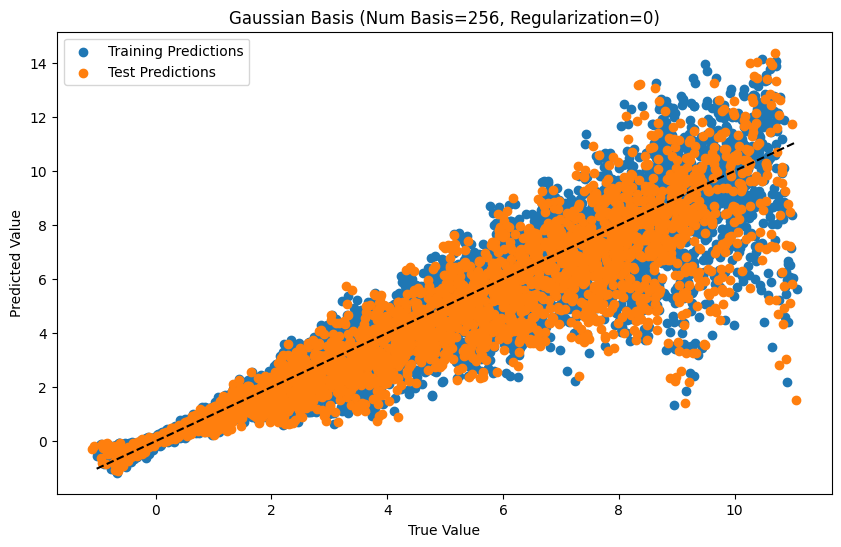

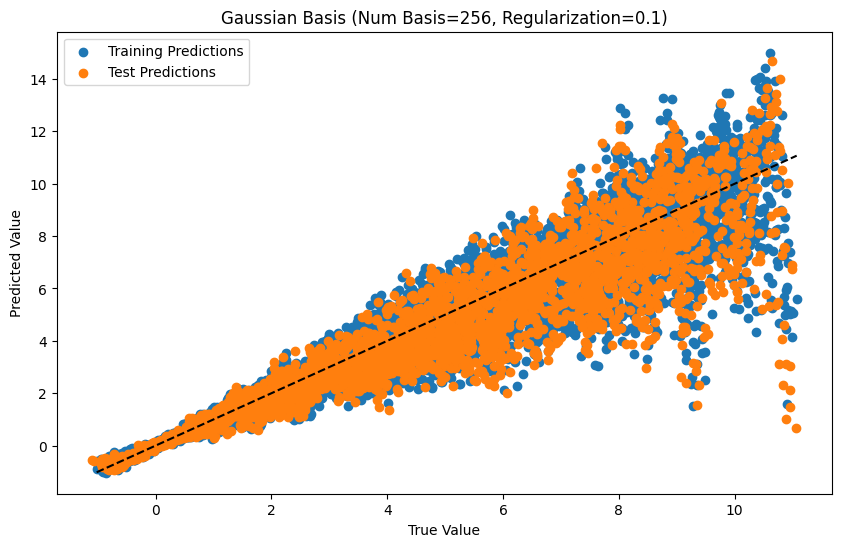

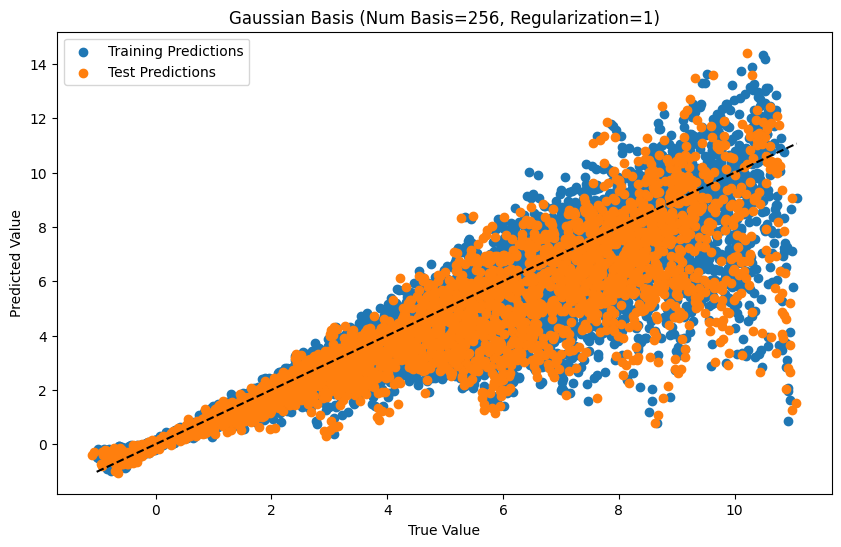

In [6]:
# Plotting function for Dataset 2
def plot_gaussian_basis_fit(train_data, test_data, num_basis_values, reg_lambda_values):
    X_train = train_data[['x1', 'x2']].values
    y_train = train_data['y'].values
    X_test = test_data[['x1', 'x2']].values
    y_test = test_data['y'].values

    for num_basis in num_basis_values:
        for reg_lambda in reg_lambda_values:
            weights, centers, sigma = gaussian_basis_regression(X_train, y_train, num_basis, reg_lambda)
            train_predictions = predict_gaussian_basis(X_train, weights, centers, sigma)
            test_predictions = predict_gaussian_basis(X_test, weights, centers, sigma)

            # Plot predictions vs. actual values
            plt.figure(figsize=(10, 6))
            plt.scatter(y_train, train_predictions, label='Training Predictions')
            plt.scatter(y_test, test_predictions, label='Test Predictions')
            plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
            plt.xlabel('True Value')
            plt.ylabel('Predicted Value')
            plt.title(f'Gaussian Basis (Num Basis={num_basis}, Regularization={reg_lambda})')
            plt.legend()
            plt.show()

# Example of calling plot function
plot_gaussian_basis_fit(train_data2, test_data2, num_basis_values=[2, 4, 8, 16, 32, 128, 256], reg_lambda_values=[0, 0.1, 1])